# Homework 04
https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/04-evaluation/homework.md

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column card).

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-03 20:24:45--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  38.3KB/s    in 1.9s    

2022-10-03 20:24:48 (38.3 KB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [22]:
import pandas as pd
import numpy as np

In [23]:
df = pd.read_csv('AER_credit_card_data.csv')

In [24]:
df.head().T

,0,1,2,3,4
card,yes,yes,yes,yes,yes
reports,0,0,0,0,0
age,37.66667,33.25,33.66667,30.5,32.16667
income,4.52,2.42,4.5,2.54,9.7867
share,0.03327,0.005217,0.004156,0.065214,0.067051
expenditure,124.9833,9.854167,15.0,137.8692,546.5033
owner,yes,no,yes,no,yes
selfemp,no,no,no,no,no
dependents,3,3,4,0,2
months,54,34,58,25,64


In [25]:
df.nunique()

card              2
reports          13
age             418
income          431
share          1162
expenditure     981
owner             2
selfemp           2
dependents        7
months          193
majorcards        2
active           35
dtype: int64

In [26]:
df.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [27]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'active']
categorical = ['owner', 'selfemp', 'majorcards']

In [28]:
df['card_target'] = (df['card'] == 'yes').astype(int)

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [31]:
import matplotlib.pyplot as plt

## Question 01

In [48]:
from sklearn.metrics import roc_curve, auc

In [57]:
auc_list = []
for var in numerical:
    fpr, tpr, thresholds = roc_curve( df_train['card_target'], df_train[var])
    if auc(fpr, tpr) < 0.5:
        fpr, tpr, thresholds = roc_curve( df_train['card_target'], -df_train[var])
    auc_list.append(auc(fpr, tpr))
pd.DataFrame(dict(zip(numerical, auc_list)).items()).sort_values(1, ascending=False)

,0,1
4,expenditure,0.991042
3,share,0.989184
0,reports,0.716663
7,active,0.604317
2,income,0.590805
5,dependents,0.532776
6,months,0.529422
1,age,0.524002


## Question 02

In [58]:
features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [90]:
from sklearn.feature_extraction import DictVectorizer

In [91]:
dv = DictVectorizer(sparse=False)

In [92]:
train_dicts = df_train[features].to_dict(orient='records')

In [93]:
X_train = dv.fit_transform(train_dicts)
y_train = df_train['card_target'].values

In [94]:
from sklearn.linear_model import LogisticRegression

In [95]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [96]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [97]:
val_dicts = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val['card_target'].values

In [126]:
y_pred = model.predict_proba(X_val)[:,1]

In [127]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [128]:
roc_curve(y_val, y_pred)

(array([0.        , 0.        , 0.        , 0.01886792, 0.01886792,
        0.09433962, 0.09433962, 0.13207547, 0.13207547, 0.16981132,
        0.16981132, 0.33962264, 0.33962264, 1.        ]),
 array([0.        , 0.84834123, 0.96682464, 0.96682464, 0.97156398,
        0.97156398, 0.98104265, 0.98104265, 0.98578199, 0.98578199,
        0.99526066, 0.99526066, 1.        , 1.        ]),
 array([2.00000000e+00, 1.00000000e+00, 9.62093642e-01, 8.47847217e-01,
        4.15690738e-01, 3.02143316e-01, 2.32127974e-01, 1.71474287e-01,
        1.70806367e-01, 1.52147659e-01, 1.38364922e-01, 9.82882887e-02,
        7.08023525e-02, 1.17336215e-08]))

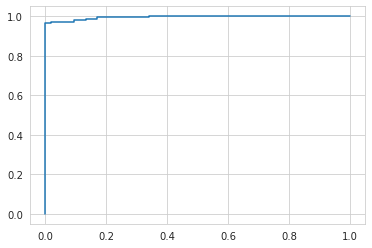

In [129]:
plt.plot(fpr, tpr)

In [130]:
auc(fpr, tpr).round(3)

0.995

## Questions 03, 04

In [131]:
from sklearn.metrics import accuracy_score

In [132]:
thresholds = np.linspace(0, 1, 101)

In [137]:
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.799
0.01 0.871
0.02 0.883
0.03 0.909
0.04 0.917
0.05 0.917
0.06 0.928
0.07 0.928
0.08 0.928
0.09 0.928
0.10 0.932
0.11 0.932
0.12 0.932
0.13 0.955
0.14 0.955
0.15 0.955
0.16 0.962
0.17 0.962
0.18 0.962
0.19 0.966
0.20 0.966
0.21 0.966
0.22 0.966
0.23 0.966
0.24 0.962
0.25 0.962
0.26 0.962
0.27 0.962
0.28 0.962
0.29 0.962
0.30 0.958
0.31 0.962
0.32 0.962
0.33 0.962
0.34 0.970
0.35 0.973
0.36 0.973
0.37 0.973
0.38 0.973
0.39 0.973
0.40 0.973
0.41 0.973
0.42 0.970
0.43 0.970
0.44 0.970
0.45 0.970
0.46 0.970
0.47 0.970
0.48 0.970
0.49 0.970
0.50 0.970
0.51 0.970
0.52 0.970
0.53 0.970
0.54 0.970
0.55 0.970
0.56 0.970
0.57 0.970
0.58 0.970
0.59 0.970
0.60 0.970
0.61 0.970
0.62 0.970
0.63 0.970
0.64 0.970
0.65 0.970
0.66 0.970
0.67 0.970
0.68 0.970
0.69 0.970
0.70 0.970
0.71 0.970
0.72 0.970
0.73 0.970
0.74 0.970
0.75 0.970
0.76 0.970
0.77 0.970
0.78 0.970
0.79 0.970
0.80 0.970
0.81 0.970
0.82 0.970
0.83 0.970
0.84 0.970
0.85 0.973
0.86 0.973
0.87 0.973
0.88 0.973
0.89 0.973
0.90 0.973

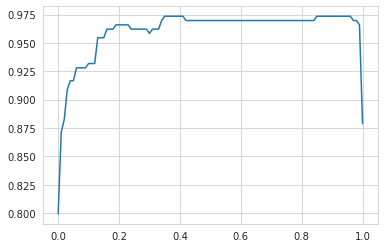

In [138]:
plt.plot(thresholds, scores)

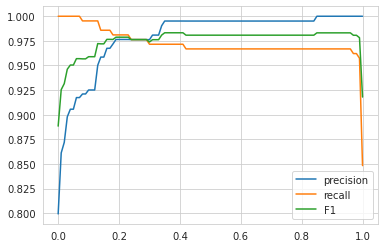

In [146]:
scores0 = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores0.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores0, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores['f1'] = 2 * ((df_scores.p * df_scores.r) / (df_scores.p + df_scores.r))

plt.plot(df_scores.threshold, df_scores['p'], label='precision')
plt.plot(df_scores.threshold, df_scores['r'], label='recall')
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')

# plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
# plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [140]:
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,211,53,0,0,1.000000,1.000000
1,0.01,211,34,0,19,1.000000,0.641509
2,0.02,211,31,0,22,1.000000,0.584906
3,0.03,211,24,0,29,1.000000,0.452830
4,0.04,211,22,0,31,1.000000,0.415094
...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,0.966825,0.000000
97,0.97,203,0,8,53,0.962085,0.000000
98,0.98,203,0,8,53,0.962085,0.000000
99,0.99,202,0,9,53,0.957346,0.000000


## Questions 5, 6

In [156]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [157]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred



In [159]:
n_splits = 5

for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card_target.values
        y_val = df_val.card_target.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.5f +- %.3f' % (C, np.mean(scores), np.std(scores)))



C=0.01 0.99188 +- 0.006
C=0.1 0.99506 +- 0.004
C=1 0.99645 +- 0.003
C=10 0.99639 +- 0.003
